## Dataset Exploration

First, we have a simple look at the pictures in the dataset. There are two kinds of views, lateral
and frontal. 

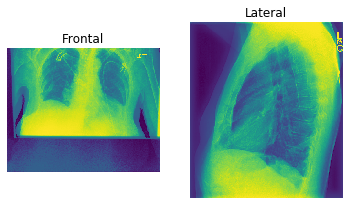

In [153]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# image saved as numpy array
fig, axs = plt.subplots(ncols=2)
axs[0].set_title('Frontal')
axs[0].axis('off')
frontal = mpimg.imread('dev_dataset/CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg')
axs[0].imshow(frontal)
axs[1].set_title('Lateral')
axs[1].axis('off')
lateral = mpimg.imread('dev_dataset/CheXpert-v1.0-small/train/patient00097/study1/view2_lateral.jpg')
axs[1].imshow(lateral)
plt.show()

We load the pictures into a numpy array so we can later calculate mean images, do color analysis, etc.

In [154]:
# when doing this with the train data the IOPub data rate is exceeded, hence we use valid for now
import os 
import numpy as np
lateral_list = []
frontal_list = []
patients = os.listdir('dev_dataset/CheXpert-v1.0-small/valid')
for patient in patients:
    studies = os.listdir(os.path.join('dev_dataset/CheXpert-v1.0-small/valid', patient))
    for study in studies:
        views = os.listdir(os.path.join('dev_dataset/CheXpert-v1.0-small/valid', patient, study))
        for view in views:
            path = os.path.join('dev_dataset/CheXpert-v1.0-small/valid', patient, study, view)
            if 'lateral' in view:
                lateral_list.append(mpimg.imread(path))
            else:
                frontal_list.append(mpimg.imread(path))
print('# of dimensions in one picture:', frontal_list[0].ndim)

# of dimensions in one picture: 2


The pictures in the dataset are of varying size, so we take a look at the dimensions of the images. This information needs to be
considered when preprocessing the dataset.

In [155]:
frontal_dimensions = []
for img in frontal_list:
    dim = (len(img), len(img[0]))
    if dim not in frontal_dimensions:
        frontal_dimensions.append(dim)
print('dimensions of frontal images:')
print(frontal_dimensions)

lateral_dimensions = []
for img in lateral_list:
    dim = (len(img), len(img[0]))
    if dim not in lateral_dimensions:
        lateral_dimensions.append(dim)
print('dimensions of lateral images:')
print(lateral_dimensions)

dimensions of frontal images:
[(320, 390), (320, 320), (320, 375), (372, 320), (320, 389), (320, 323), (328, 320), (320, 369), (329, 320), (320, 397), (320, 321), (333, 320), (320, 396), (320, 332), (320, 357), (320, 383), (320, 373), (320, 341), (320, 384), (320, 379), (320, 378), (320, 352), (320, 368)]
dimensions of lateral images:
[(369, 320), (374, 320), (320, 320), (390, 320), (380, 320), (377, 320), (329, 320), (401, 320), (368, 320), (433, 320), (324, 320), (389, 320)]


We scale all input images to the same size (512x512) using interpolation and calculate a 
mean image over all input images to get an intuition of what the data looks like.

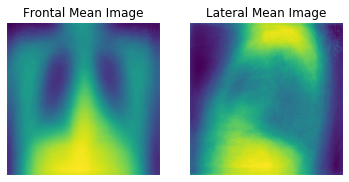

In [156]:
from src.preprocessing.rescaling import Scaler
frontal_resized = [Scaler.Scaler(img, 512).resize('LINEAR') for img in frontal_list]
lateral_resized = [Scaler.Scaler(img, 512).resize('LINEAR') for img in lateral_list]
mean_frontal = np.zeros((512, 512), np.float)
mean_lateral = np.zeros((512, 512), np.float)

for img in lateral_resized:
    mean_lateral = mean_lateral + img /len(lateral_resized)
for img in frontal_resized:
    mean_frontal = mean_frontal + img /len(frontal_resized)

fig, axs = plt.subplots(ncols=2)
axs[0].set_title('Frontal Mean Image')
axs[0].axis('off')
axs[0].imshow(mean_frontal)
axs[1].set_title('Lateral Mean Image')
axs[1].axis('off')
axs[1].imshow(mean_lateral)
plt.show()

In addition to the images, we have patient-related features and picture metadata in the dataset.

In [162]:
import pandas as pd
targets = pd.read_csv('dev_dataset/valid.csv')
column_names = np.array(targets.columns)
print('Patient Information: ', column_names[2:4])
print('Metadata: ', column_names[4:6])

Patient Information:  ['Sex' 'Age']
Metadata:  ['Frontal/Lateral' 'AP/PA']


As seen previously, there are two different views: frontal and lateral.

In [164]:
combined, num_frontal, num_lateral = 0, 0, 0
patients = os.listdir('dev_dataset/CheXpert-v1.0-small/train')
for patient in patients:
    studies = os.listdir(os.path.join('dev_dataset/CheXpert-v1.0-small/train', patient))
    for study in studies:
        views = os.listdir(os.path.join('dev_dataset/CheXpert-v1.0-small/train', patient, study))
        if len(views) > 1 :
            combined += 1
        else: 
            if 'lateral' in views[0]:
                num_lateral += 1
            else:
                num_frontal += 1
print('# of studies with both frontal and lateral images: ', combined)
print('# of studies with only a frontal image: ', num_frontal)
print('# of studies with only a lateral image: ', num_lateral)

# of studies with both frontal and lateral images:  3340
# of studies with only a frontal image:  15607
# of studies with only a lateral image:  3


Next, we want to get an intuition about how the images are distributed across patients.

In [173]:
num_studies = [['1', 0], ['2', 0], ['3', 0], ['4', 0], ['5 or more', 0]]
patients = os.listdir('dev_dataset/CheXpert-v1.0-small/train')
for patient in patients:
    studies = os.listdir(os.path.join('dev_dataset/CheXpert-v1.0-small/train', patient))
    if len(studies) >= 5:
        num_studies[4][1] += 1
    else:
        num_studies[len(studies)-1][1] += 1
for x in num_studies:
    print('# of patients with', x[0] , 'studies: ', x[1])

# of patients with 1 studies:  3329
# of patients with 2 studies:  1097
# of patients with 3 studies:  589
# of patients with 4 studies:  358
# of patients with 5 or more studies:  1027


Lastly, we have a look at the diseases and their distribution in the dataset. <br>
Attention! Encoding for labels: <br>
blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive

In [192]:
data = pd.read_csv('dev_dataset/valid.csv')
labels = np.array(targets.columns[6:20])
data = data[labels].abs()
for label in labels:
    print('The pathology', label, 'is present in', round(data[label].sum()/data[label].size*100, 2), '% of the images')

The pathology No Finding is present in 16.24 % of the images
The pathology Enlarged Cardiomediastinum is present in 46.58 % of the images
The pathology Cardiomegaly is present in 29.06 % of the images
The pathology Lung Opacity is present in 53.85 % of the images
The pathology Lung Lesion is present in 0.43 % of the images
The pathology Edema is present in 19.23 % of the images
The pathology Consolidation is present in 14.1 % of the images
The pathology Pneumonia is present in 3.42 % of the images
The pathology Atelectasis is present in 34.19 % of the images
The pathology Pneumothorax is present in 3.42 % of the images
The pathology Pleural Effusion is present in 28.63 % of the images
The pathology Pleural Other is present in 0.43 % of the images
The pathology Fracture is present in 0.0 % of the images
The pathology Support Devices is present in 45.73 % of the images
